# Промежуточная аттестация по сетям искусcтвенных нейронов.

## Задание

**Ваша задача - создать классификатор изображений с помощью Keras и сверточных нейронных сетей для набора данных Fashion MNIST. Этот набор данных включает 10 меток с разными типами одежды с изображениями 28 на 28 _ в оттенках серого _. Имеется обучающий набор из 60 000 изображений и 10 000 тестовых изображений.**

Описание классов

    Label	Description
    0	    T-shirt/top
    1	    Trouser
    2	    Pullover
    3	    Dress
    4	    Coat
    5	    Sandal
    6	    Shirt
    7	    Sneaker
    8	    Bag
    9	    Ankle boot


## Данные

**Загружаем данные**


In [44]:
from keras.datasets import fashion_mnist
import numpy as np


def load_data() -> tuple[tuple[np.ndarray, np.ndarray], tuple[np.ndarray, np.ndarray]]:
    return fashion_mnist.load_data()


(train_images, train_labels), (test_images, test_labels) = load_data()

assert train_images.shape == (60000, 28, 28)
assert test_images.shape == (10000, 28, 28)
assert train_labels.shape == (60000,)
assert test_labels.shape == (10000,)

## Визаулизация датасета

**Используйте matplotlib чтобы показать пример картинки.**


In [45]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

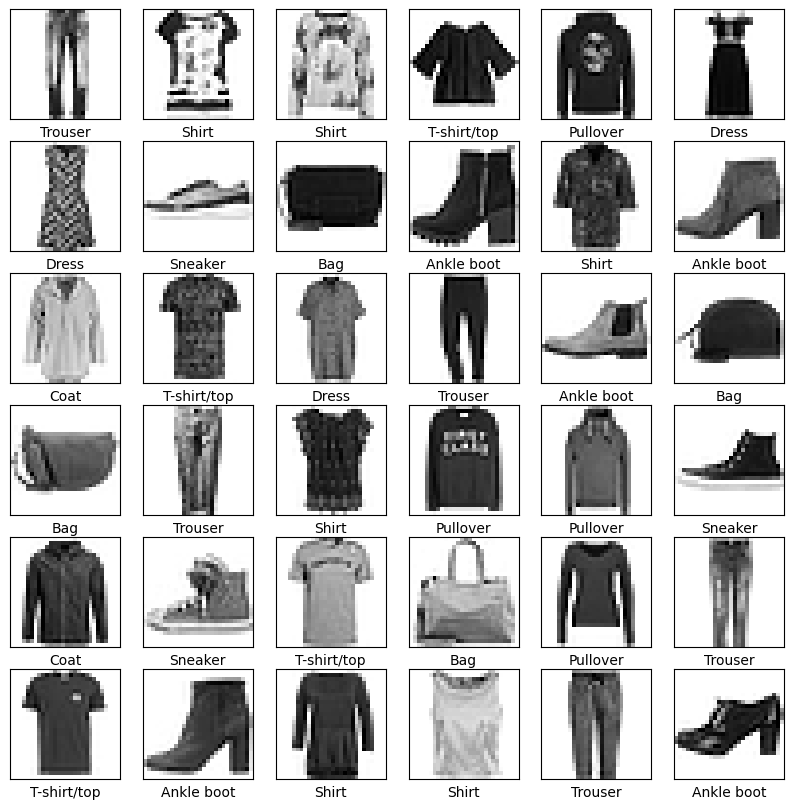

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(42)
random_idxs = np.random.choice(60000, 36)

plt.figure(figsize=(10, 10))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_idx = random_idxs[i]
    plt.imshow(np.squeeze(train_images[image_idx]), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[image_idx]])

## Предобработка

Нормализуйте данные X_train и X_test


In [47]:
train_images = (train_images / 255.0).astype(np.float32)
train_labels = (train_labels).astype(np.uint8)
test_images = (test_images / 255.0).astype(np.float32)
test_labels = (test_labels).astype(np.uint8)

### Измените форму массивов X_train и X_test так, чтобы они стали 4-мерными

batch_size x channels x H x W


In [48]:
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)

### Преобразуйте y_train и y_test в one_hot представления


In [49]:
from keras.utils import to_categorical

train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

## Создайте модель

**Примерная структура модели. При выполнении задания вы можете поэкспериментировать со слоями**

- Сверточный слой, 32 фильтра, размер ядра=(4,4)
- Пулинг с pool_size = (2,2)

- Выпрямляющий слой (Flatten)
- Полносвязный слой (например 128 нейронов), RELU

- Выходной полносвязный слой с 10 нейронами с softmax

**При компиляции укажите loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']**


In [50]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


def create_model() -> Sequential:
    model = Sequential(
        [
            Conv2D(32, kernel_size=(4, 4), activation="relu",
                   input_shape=(28, 28, 1)),
            MaxPooling2D(pool_size=(2, 2)),
            Flatten(),
            Dense(128, activation="relu"),
            Dense(10, activation="softmax"),
        ]
    )
    model.compile(
        loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"]
    )
    return model

In [51]:
model = create_model()

In [52]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 25, 25, 32)        544       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 4608)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               589952    
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 591,786
Trainable params: 591,786
Non-trainable params: 0
________________________________________________

Сохраним фильтры для отображения в дальнейшем


In [36]:
filters_before_train: np.ndarray = model.layers[0].get_weights()[0].copy()

### Тренировка модели

**Тренируем модель на x_train. Число эпох выберите самостоятельно**


In [53]:
import os
import tensorflow as tf

checkpoint_path = "checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, save_weights_only=True, verbose=1
)

In [38]:
EPOCHS = 10
BATCH_SIZE = 64


def load_model(model: Sequential, train: bool = False):
    if train:
        model.fit(
            train_images,
            train_labels,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=[cp_callback],
        )
    else:
        latest = tf.train.latest_checkpoint(checkpoint_dir)
        model.load_weights(latest)

In [39]:
train_model = True

load_model(model, train=train_model)

### Оценка модели

Оцените модель по метрикам accuracy, precision, recall, f1-score на тестовой выборке x_test


In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Предсказание на тестовой выборке
pred_labels = model.predict(test_images)
pred_labels_classes = np.argmax(pred_labels, axis=1)
true_labels = np.argmax(test_labels, axis=1)

accuracy = accuracy_score(true_labels, pred_labels_classes)
precision = precision_score(true_labels, pred_labels_classes, average="macro")
recall = recall_score(true_labels, pred_labels_classes, average="macro")
f1 = f1_score(true_labels, pred_labels_classes, average="macro")

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

313/313 [==============================] - 8s 25ms/step
Accuracy: 0.9137
Precision: 0.9145880463441312
Recall: 0.9136999999999998
F1-Score: 0.913790331564611


In [41]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, pred_labels_classes, digits=4))

              precision    recall  f1-score   support

           0     0.8766    0.8670    0.8718      1000
           1     0.9979    0.9730    0.9853      1000
           2     0.8907    0.8390    0.8641      1000
           3     0.8909    0.9390    0.9143      1000
           4     0.8447    0.8810    0.8625      1000
           5     0.9849    0.9760    0.9804      1000
           6     0.7575    0.7590    0.7582      1000
           7     0.9285    0.9870    0.9569      1000
           8     0.9879    0.9790    0.9834      1000
           9     0.9863    0.9370    0.9610      1000

    accuracy                         0.9137     10000
   macro avg     0.9146    0.9137    0.9138     10000
weighted avg     0.9146    0.9137    0.9138     10000



## Дополнительно

Отрисуйте фильтры на слое Conv2D, сравните до и после обучения модели


In [42]:
from matplotlib.axes import Axes


def draw_conv2D_filters(filters: np.ndarray, title: str):
    filters_count = filters.shape[-1]
    rows_count = 4
    columns_count = 8

    figure, axes = plt.subplots(rows_count, columns_count, figsize=(8, 4))
    figure.suptitle(title)
    for i in range(rows_count):
        for j in range(columns_count):
            ax: Axes = axes[i, j]
            if i * columns_count + j < filters_count:
                f = filters[:, :, :, i * columns_count + j]
                ax.imshow(f[:, :, 0], cmap="gray")
            ax.axis("off")

    plt.show()

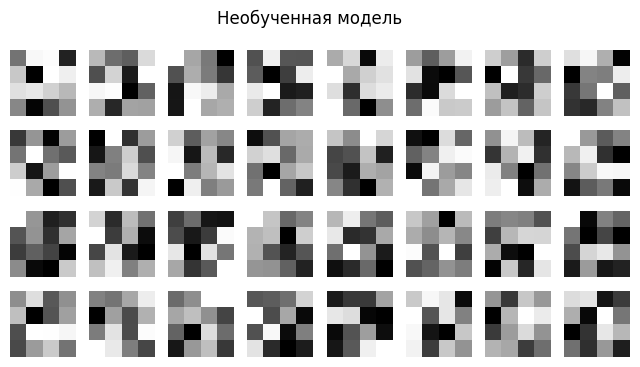

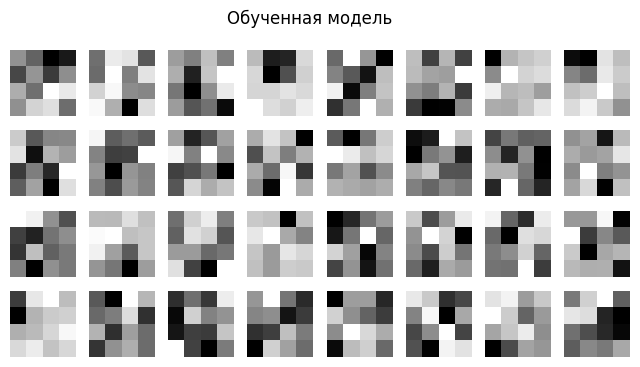

In [43]:
draw_conv2D_filters(filters_before_train, "Необученная модель")
filters_after_train = model.layers[0].get_weights()[0]
draw_conv2D_filters(filters_after_train, "Обученная модель")